# Hadoop Log Data Anomaly Detection

Author: Yilin Sun,  Song Zhang

The data we analyze are the logs generated from a Hadoop cluster. What we are going to detect the log types by modelling. 

## Data Pre-processing

First, we process the data from the log file. We create a dataframe based on the log info. We extract the date, hour, log type, information in the bracket, and the function(which is after the .hadoop) of the log. In addition, we determine if the log contains the key word "Error" or "Exception" and store the result in two columns.  

In [ ]:
import pandas as pd
import altair as alt
import re
path = "combined.log"
data = []
with open(path) as f:
    f = f.readlines()
    for line in f:
       new_line = line.split()
       if len(new_line)>3:
         if new_line[2]=="INFO" or new_line[2]=="WARN" or new_line[2]=="ERROR":
            date = new_line[0]
            hour = new_line[1]
            label = new_line[2]
            bracketsInfo= line[line.find('[')+len('['):line.find(']')]
            func = ""
            m = line.split(".hadoop.",1)
            if len(m)>1:
              func = m[1].split(".",1)[0]
            
            hasError = False
            hasException =False
            message = []
            for i in range(3,len(new_line)):
              if "Error" in new_line[i]:
                hasError = True
              if "ERROR" in new_line[i]:
                hasError = True
              if "Exception" in new_line[i]:
                hasException = True
              if "EXCEPTION" in new_line[i]:
                hasException = True
              message.append(new_line[i])
            data.append([date,hour,label,bracketsInfo,hasError,hasException,func,message])


df = pd.DataFrame(data, columns=['date', 'hour', 'label','bracketsInfo','hasError','hasException','func','message'])


In [ ]:
df.head(5)

,date,hour,label,bracketsInfo,hasError,hasException,func,message
0,2015-10-17,"15:37:56,547",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
1,2015-10-17,"15:37:56,899",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
2,2015-10-17,"15:37:56,900",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
3,2015-10-17,"15:37:57,036",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
4,2015-10-17,"15:37:57,634",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."


Next, we show the details of the different label. 

In [ ]:
df0 = df[df["label"]=='INFO']
len(df0)


120519

In [ ]:
df1 = df[df["label"]=='WARN']
len(df1)

6164

In [ ]:
df2 = df[df["label"]=='ERROR']
len(df2)

336

For the dataset, it is too large(more than 120k rows) and it took a long time to build the model later. Also in contrast to INFO, the ERROR and WARN info is not too much. So we extract the data to 15000 rows which contain all the ERROR and WARN and extract the INFO row for the rest.

In [ ]:
num  = 15000-len(df1)-len(df2)
df3 = df0.head(num)
frames = [df1,df2,df3]
df = pd.concat(frames)
df = df.sample(frac=1)
df.head(5)

,date,hour,label,bracketsInfo,hasError,hasException,func,message
63764,2015-10-18,"18:25:28,974",WARN,LeaseRenewer:msrabi@msra-sa-41:9000,False,False,hdfs,"[[LeaseRenewer:msrabi@msra-sa-41:9000], org.ap..."
73632,2015-10-18,"18:06:53,656",WARN,LeaseRenewer:msrabi@msra-sa-41:9000,False,False,ipc,"[[LeaseRenewer:msrabi@msra-sa-41:9000], org.ap..."
73400,2015-10-18,"18:05:47,008",WARN,RMCommunicator Allocator,False,False,ipc,"[[RMCommunicator, Allocator], org.apache.hadoo..."
62820,2015-10-18,"18:17:34,992",WARN,LeaseRenewer:msrabi@msra-sa-41:9000,False,False,hdfs,"[[LeaseRenewer:msrabi@msra-sa-41:9000], org.ap..."
726,2015-10-17,"15:40:09,159",INFO,IPC Server handler 21 on 47468,False,False,mapred,"[[IPC, Server, handler, 21, on, 47468], org.ap..."


## Exploratory Data Analysis



1. count error label based on brackets info. 

In [ ]:
p1=alt.Chart(df2).mark_bar().encode(
    x='bracketsInfo',
y='count()',
   
)


2. error count based on the date.

In [ ]:
p2=alt.Chart(df2).mark_bar().encode(
    x='date',
y='count()',
   
)


3. error count based on func.

In [ ]:
p3=alt.Chart(df2).mark_bar().encode(
    x='func',
y='count()',
   
)

In [ ]:
p1+p2+p3

alt.LayerChart(...)

We can see that most error label appears in mapreduce function and appear at 2015-10-18. For the details information in the bracket, the error is mainly due to RMCommunicator Allocator.

## Modeling

In [ ]:
!pip install torch torchvision
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import sqlite3
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Feature Engineering

First, we need to change the label to integer, and extract the bracketsInfo, func, hasError and hasException as the feature for the modeling. We will apply one-hot-encoding to all of the features.

In [ ]:
dict_mode = {'INFO':1,'WARN':2,'ERROR':3}
df=df.replace({"label": dict_mode})
df.label = df.label.astype('category')
df.bracketsInfo = df.bracketsInfo.astype('category')
df.func = df.func.astype('category')
df.hasError = df.hasError.astype('boolean')
df.hasException = df.hasException.astype('boolean')
df=df.drop(columns=['message','date','hour'])

In [ ]:
feature_df = pd.get_dummies(df,prefix=['bracketsInfo','func','hasError','hasException'],columns=['bracketsInfo','func','hasError','hasException'])

Next, we separate the dataset to training and testing set.We use 80%:20% for the training and testing set split. 


In [ ]:
from sklearn.model_selection import train_test_split
labeld = feature_df['label']
featured = feature_df.loc[:, feature_df.columns != 'label']
x_train, x_test, y_train, y_test = train_test_split(featured,labeld,test_size=0.2)


In [ ]:
x_train.shape

(12000, 206)

### Logistic Regression

First, we use logistic regression.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix,plot_confusion_matrix

clf = LogisticRegression(max_iter=10)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred)
print("mse of logistic regression is: ", mse_test)

mse of logistic regression is:  0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from sklearn.metrics import accuracy_score
acc_test = accuracy_score(y_test, y_pred)
print("accuracy score is: ", acc_test)

accuracy score is:  0.994


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


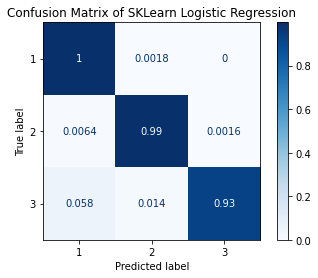

In [ ]:
disp = plot_confusion_matrix(clf, x_test, y_test,cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('Confusion Matrix of SKLearn Logistic Regression')

plt.show()

In [ ]:
coef_df = pd.DataFrame(clf.coef_,columns=x_train.columns,
                       index=['INFO','WARN','ERROR'])
coef_df

,bracketsInfo_AsyncDispatcher event handler,bracketsInfo_CommitterEvent Processor #0,bracketsInfo_CommitterEvent Processor #1,bracketsInfo_CommitterEvent Processor #2,bracketsInfo_CommitterEvent Processor #3,bracketsInfo_CommitterEvent Processor #4,bracketsInfo_ContainerLauncher #0,bracketsInfo_ContainerLauncher #1,bracketsInfo_ContainerLauncher #2,bracketsInfo_ContainerLauncher #3,...,func_ipc,func_mapred,func_mapreduce,func_metrics2,func_service,func_yarn,hasError_False,hasError_True,hasException_False,hasException_True
INFO,1.348844,-0.787585,-2.153322,-1.618654,-1.477292,-0.926999,0.127211,1.192226,1.295798,0.113721,...,-0.861155,2.753402,-0.818330,0.315590,-0.096239,0.662930,2.119418,-1.722680,1.235353,-0.838615
WARN,-1.119601,0.800407,2.193163,1.645415,1.501388,0.939304,-0.110729,-1.150119,-1.249228,-0.099734,...,1.630146,-2.022225,-0.614227,-0.283934,0.098148,-0.715477,1.026668,-0.817019,-0.469997,0.679646
ERROR,-0.229244,-0.012821,-0.039841,-0.026761,-0.024095,-0.012305,-0.016482,-0.042107,-0.046571,-0.013987,...,-0.768991,-0.731177,1.432557,-0.031656,-0.001909,0.052548,-3.146086,2.539698,-0.765356,0.158969


### Random Forest Classifier

We focus on building better classifiers and used grid search to find an optimal combination of estimators and max depths.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_estimators = 5, max_depth=5)

# use grid search and train a random forest model on the transformed train dataset.
param_grid = { 
    'n_estimators': [8,10,12],
    'max_depth': [5,8,10]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(x_train, y_train)
print(CV_rfc.best_params_)

{'max_depth': 8, 'n_estimators': 10}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

rfc = RandomForestClassifier(n_estimators = 10, max_depth=10)
rfc.fit(x_train,y_train)

y_pred = rfc.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred)
print("mse of random forest is: ", mse_test)

mse of random forest is:  0.013666666666666667


In [ ]:
from sklearn.metrics import accuracy_score
acc_test = accuracy_score(y_test, y_pred)
print("accuracy score is: ", acc_test)

accuracy score is:  0.9903333333333333


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


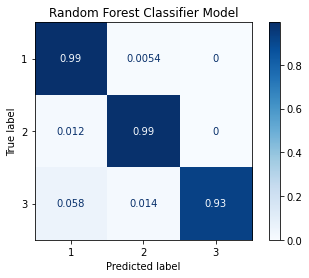

In [ ]:
disp = plot_confusion_matrix(rfc, x_test, y_test,cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('Random Forest Classifier Model')
plt.show()

### Multilayer perceptrons (Feedforward neural Network)

Next, we will use PyTorch to train a FNN model.

#### Convert data to Tensors

Convert the data to Tensors, so that PyTorch can use the data.

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = CreateDataset(torch.from_numpy(np.array(x_train)).float(), torch.from_numpy(np.array(y_train)).long())
test_dataset = CreateDataset(torch.from_numpy(np.array(x_test)).float(), torch.from_numpy(np.array(y_test)).long())

#### Create Data Loader

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#### Weighted Sampling

Define a function to create a dictionary with the frequency of each class.

In [ ]:
def create_frequency_dict(y_train):
  count_dict = {
    "INFO": 0,
    "WARN": 0,
    "ERROR": 0, }
  labels = np.array(y_train)
  for i in labels:
    if i == 1: 
      count_dict["INFO"] += 1
    if i == 2:
      count_dict["WARN"] += 1
    elif i == 3: 
      count_dict["ERROR"] += 1
           
        
  return count_dict

In [ ]:
create_frequency_dict(y_train)

{'ERROR': 267, 'INFO': 6825, 'WARN': 4908}

Calculate the weight for each class

In [ ]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

class_count = [i for i in create_frequency_dict(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0001, 0.0002, 0.0037])


#### Define Model

Define and initialize an Multilayer perceptrons(FNN) model.

In [ ]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, n_features, n_labels):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(n_features, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32) 
        self.fc5 = nn.Linear(32, n_labels)  
    
    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      out = self.fc5(x)
      return out

In [ ]:
n_features = 206
n_labels = 5
fnn_model = FeedforwardNeuralNetModel(n_features, n_labels)

In [ ]:
fnn_input_dim = 206
summary(fnn_model.to(device), (1, fnn_input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         105,984
            Linear-2               [-1, 1, 128]          65,664
            Linear-3                [-1, 1, 64]           8,256
            Linear-4                [-1, 1, 32]           2,080
            Linear-5                 [-1, 1, 5]             165
Total params: 182,149
Trainable params: 182,149
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.69
Estimated Total Size (MB): 0.70
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
learning_rate = 0.0001
fnn_optimizer = torch.optim.Adam(fnn_model.parameters(), lr=learning_rate)

#### Train Model

Define a function to train the model.

In [ ]:
def train_model(model, optimizer, criterion, epochs=10):
    for child in model.children():
      if hasattr(child, 'reset_parameters'):
        child.reset_parameters()
    model.train()
    model.to(device)

    loss_list = []
    accuracy_list = []
    for epoch in range(int(epochs)):
      correct = 0
      total = 0
      running_loss = 0.0
      for x_train_batch, y_train_batch in train_loader:
        x_train_batch, y_train_batch = x_train_batch.to(device), y_train_batch.to(device)
        # Clear gradients parameters
        optimizer.zero_grad()
        # Forward pass to get output
        outputs = model(x_train_batch)
        # Compute the loss
        loss = criterion(outputs, y_train_batch)
        # Compute the gradients for each of the model parameters
        loss.backward()
        # Use the optimizer to update the weights
        optimizer.step()

        # Calculate the accuracy
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        # Total number of labels
        total += y_train_batch.size(0)
        # Total correct predictions
        correct += (predicted == y_train_batch).sum().item()
        
        # Calculate the loss
        running_loss += loss.item()
      
      loss = running_loss / len(train_loader)
      accuracy = correct / total
      accuracy_list.append(accuracy)
      loss_list.append(loss)
      print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss, accuracy))
    print(loss_list)
    print(accuracy_list)
    
    final_training_accuracy = accuracy_list[-1]
    final_training_loss = loss_list[-1]
    return final_training_loss, final_training_accuracy, loss_list, accuracy_list

In [ ]:
fnn_epochs = 10
fnn_training_loss, fnn_training_accuracy, loss_list, accuracy_list = train_model(fnn_model, fnn_optimizer, criterion, fnn_epochs)

print("Feedforward Neural Network - the training loss is ", str(fnn_training_loss))
print("Feedforward Neural Network - the training accuracy is ", str(fnn_training_accuracy))

Epoch: 0. Loss: 0.1056828047380765. Accuracy: 0.9624166666666667
Epoch: 1. Loss: 0.02542043393533473. Accuracy: 0.9939166666666667
Epoch: 2. Loss: 0.020378831683712482. Accuracy: 0.9945833333333334
Epoch: 3. Loss: 0.018704800471287465. Accuracy: 0.9953333333333333
Epoch: 4. Loss: 0.018032230373017783. Accuracy: 0.99575
Epoch: 5. Loss: 0.017399105577552268. Accuracy: 0.9958333333333333
Epoch: 6. Loss: 0.016870069260967097. Accuracy: 0.996
Epoch: 7. Loss: 0.016532881949948012. Accuracy: 0.9963333333333333
Epoch: 8. Loss: 0.01662792827710434. Accuracy: 0.996
Epoch: 9. Loss: 0.01639336445861797. Accuracy: 0.9961666666666666
[0.1056828047380765, 0.02542043393533473, 0.020378831683712482, 0.018704800471287465, 0.018032230373017783, 0.017399105577552268, 0.016870069260967097, 0.016532881949948012, 0.01662792827710434, 0.01639336445861797]
[0.9624166666666667, 0.9939166666666667, 0.9945833333333334, 0.9953333333333333, 0.99575, 0.9958333333333333, 0.996, 0.9963333333333333, 0.996, 0.9961666666

Text(0, 0.5, 'Loss')

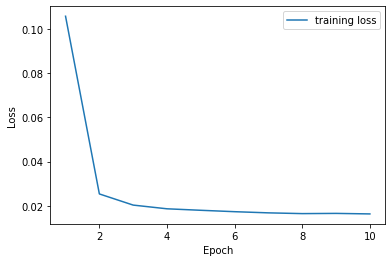

In [ ]:
from matplotlib import pyplot as plt
epoch_list=list()
for i in range(1, 11):
  epoch_list.append(i)
plt.plot(epoch_list, loss_list, label='training loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

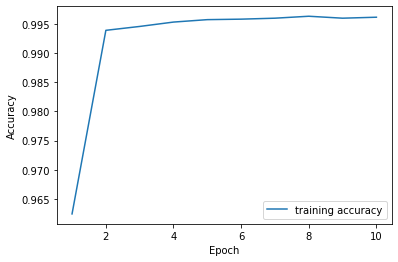

In [ ]:
plt.plot(epoch_list, accuracy_list, label='training accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

#### Evaluate Model

In [ ]:
def test_model(model, criterion):
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0
    for x_test_batch, y_test_batch in train_loader:
      x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
      outputs = model(x_test_batch)

      loss = criterion(outputs, y_test_batch)

      _, predicted = torch.max(outputs.data, 1)
      total += y_test_batch.size(0)
      correct += (predicted == y_test_batch).sum().item()

      running_loss += loss.item()

    testing_accuracy =  correct / total
    testing_loss = running_loss / len(test_loader)

    return  testing_loss, testing_accuracy

In [ ]:
fnn_testing_loss, fnn_testing_accuracy = test_model(fnn_model, criterion)

print("Feedforward Neural Network - the testing loss is ", str(fnn_testing_loss))
print("Feedforward Neural Network - the testing accuracy is ", str(fnn_testing_accuracy))


Feedforward Neural Network - the testing loss is  0.057627981389273414
Feedforward Neural Network - the testing accuracy is  0.9963333333333333


The accuracy of FNN model is 0.99633, which is higher than the logistic model. 

## Conclusion

We can see that the accuracy rate is high, and the multilayer perceptrons model has a higher accuracy rate than the logistic regression model. So the anomaly can be easily distinguished based on the model.